In [1]:
## Code for reading external HuggingFace token, if necessary
def get_huggingface_token():
    f = open("huggingface_token.txt", "r")
    return (f.read())

In [20]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2')

# Input list of texts
text_list = ["make google.com", "compile google.com", "memory overflow"]

# Tokenize the list of texts
inputs = tokenizer(text_list, padding=True, truncation=True, return_tensors='pt')

# Pass through the model
with torch.no_grad():  # Disable gradient calculation for efficiency
    outputs = model(**inputs)

# Extract embeddings (typically using the mean of the last hidden state)
embeddings = outputs.last_hidden_state.mean(dim=1)  # Shape: (batch_size, embedding_dim)

print(embeddings.shape)  # Should print (number_of_texts, embedding_dim)
print(embeddings)

torch.Size([3, 768])
tensor([[ 0.0183,  0.2653, -0.0577,  ..., -0.0023, -0.0354, -0.0586],
        [-0.0092,  0.1623, -0.1112,  ..., -0.1113, -0.0952, -0.0914],
        [-0.0120, -0.0851, -0.0942,  ..., -0.0145,  0.0720, -0.0198]])


In [15]:
import openai

# Function to read OpenAI API key from a file
def get_openai_token():
    with open("openai_token.txt", "r") as f:
        return f.read().strip()

# Initialize OpenAI client with API key
client = openai.OpenAI(api_key=get_openai_token())

# Input list of texts
text_list = ["Text example one", "Text example two", "Another text"]

# Generate embeddings using the updated API
# Low = text-embedding-ada-002
# Medium = text-embedding-3-small
# High = text-embedding-3-large

response = client.embeddings.create(
    input=text_list,
    model="text-embedding-ada-002"
)

# Extract embeddings
embeddings = [embedding.embedding for embedding in response.data]

# Print the shape of embeddings
print(f"Number of embeddings: {len(embeddings)}, Embedding dimension: {len(embeddings[0])}")


Number of embeddings: 3, Embedding dimension: 1536


In [21]:
print(embeddings)

tensor([[ 0.0183,  0.2653, -0.0577,  ..., -0.0023, -0.0354, -0.0586],
        [-0.0092,  0.1623, -0.1112,  ..., -0.1113, -0.0952, -0.0914],
        [-0.0120, -0.0851, -0.0942,  ..., -0.0145,  0.0720, -0.0198]])


In [18]:
import pandas as pd
output = pd.DataFrame(embeddings)
print(output)

       0         1         2         3         4         5         6     \
0  0.000250  0.003947  0.010360 -0.007900 -0.001091  0.015432 -0.016862   
1 -0.004110  0.002129  0.012336 -0.008911 -0.000003  0.025502 -0.015267   
2 -0.023793 -0.000496 -0.003711 -0.009407  0.006024  0.037128 -0.003636   

       7         8         9     ...      1526      1527      1528      1529  \
0 -0.000882 -0.013516 -0.020327  ... -0.002331  0.002569  0.023437 -0.015130   
1 -0.002266 -0.013074 -0.010611  ... -0.002992  0.003721  0.018323 -0.015689   
2 -0.007285 -0.008579 -0.002890  ...  0.004776 -0.015634  0.012987 -0.009742   

       1530      1531      1532      1533      1534      1535  
0 -0.015708 -0.002375 -0.004275 -0.009304 -0.012690 -0.030628  
1 -0.009320 -0.003675 -0.012771 -0.015386 -0.020642 -0.027030  
2 -0.010405  0.029035  0.000916 -0.033370 -0.009939 -0.016698  

[3 rows x 1536 columns]


Loaded embeddings: 3 logs, 768-dimensional each
Epoch 0, Loss: 0.0368
Epoch 100, Loss: 0.0000
Epoch 200, Loss: 0.0000
Epoch 300, Loss: 0.0000
Epoch 400, Loss: 0.0000

Causal Influence (Prediction Errors):
      Feature_0  Feature_1     Feature_2     Feature_3     Feature_4  \
0  3.883615e-07   0.000002  1.139939e-06  5.215406e-07  1.426786e-06   
1  2.216548e-07   0.000001  9.685755e-08  9.685755e-08  6.407499e-07   

      Feature_5  Feature_6     Feature_7     Feature_8     Feature_9  ...  \
0  1.564622e-06   0.000001  3.594905e-07  2.235174e-06  1.274049e-06  ...   
1  5.774200e-07   0.000001  9.685755e-08  8.121133e-07  4.246831e-07  ...   

    Feature_758   Feature_759   Feature_760   Feature_761   Feature_762  \
0  1.642853e-06  8.046627e-07  1.590699e-06  1.002103e-06  2.235174e-06   
1  1.937151e-07  7.543713e-08  8.046627e-07  2.644956e-07  4.991889e-07   

    Feature_763   Feature_764   Feature_765  Feature_766   Feature_767  
0  2.950430e-06  2.995133e-06  2.883375e-06    

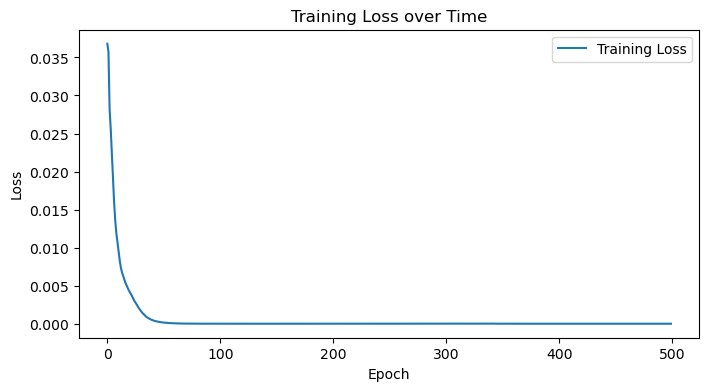

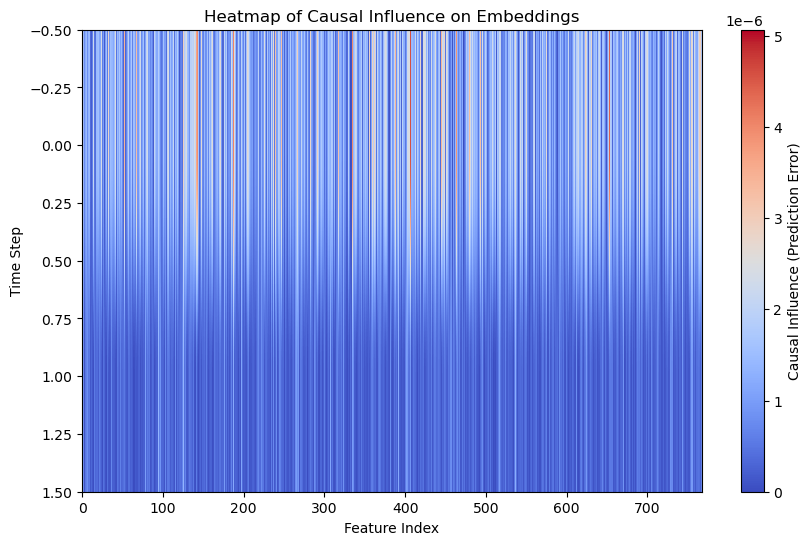

In [22]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ==========================
# Step 1: Load Your Embeddings
# ==========================
# Replace this with your actual list of embeddings (must be a list of NumPy arrays or a 2D NumPy array)
your_embeddings_list = embeddings

# Convert to NumPy array
embeddings_array = np.array(your_embeddings_list)

# Convert to PyTorch tensor
embedding_tensor = torch.tensor(embeddings_array, dtype=torch.float32)

# Check dimensions
num_logs, embedding_dim = embedding_tensor.shape
print(f"Loaded embeddings: {num_logs} logs, {embedding_dim}-dimensional each")

# ==========================
# Step 2: Define Causal LSTM Model
# ==========================
class CausalLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CausalLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, input_dim)  # Predict next embeddings

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out)

# Instantiate Model
hidden_dim = 16  # Hidden state size
model = CausalLSTM(embedding_dim, hidden_dim)

# ==========================
# Step 3: Define Loss and Optimizer
# ==========================
criterion = nn.MSELoss()  # Predict next embedding, compare with ground truth
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Prepare Data: Reshape for LSTM (batch_size=1, sequence_length=num_logs, feature_dim=embedding_dim)
train_data = embedding_tensor.unsqueeze(0)  # (1, num_logs, embedding_dim)

# ==========================
# Step 4: Train Model
# ==========================
epochs = 500
losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    output = model(train_data[:, :-1, :])  # Predict next time steps
    loss = criterion(output, train_data[:, 1:, :])  # Compare with real next-step embeddings
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# ==========================
# Step 5: Evaluate Causal Influence
# ==========================
with torch.no_grad():
    predictions = model(train_data[:, :-1, :]).squeeze(0).numpy()

# Compute causal influence (prediction errors)
causal_effects = np.abs(predictions - embeddings_array[1:, :])

# Convert to DataFrame for easy visualization
causal_df = pd.DataFrame(causal_effects, columns=[f"Feature_{i}" for i in range(embedding_dim)])
print("\nCausal Influence (Prediction Errors):")
print(causal_df)

# ==========================
# Step 6: Visualize Results
# ==========================
plt.figure(figsize=(8, 4))
plt.plot(losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Time")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.imshow(causal_effects, cmap="coolwarm", aspect="auto")
plt.colorbar(label="Causal Influence (Prediction Error)")
plt.xlabel("Feature Index")
plt.ylabel("Time Step")
plt.title("Heatmap of Causal Influence on Embeddings")
plt.show()


Loaded embeddings: 162 logs, 768-dimensional each
Epoch 0, Loss: 0.0444
Epoch 100, Loss: 0.0062
Epoch 200, Loss: 0.0050
Epoch 300, Loss: 0.0041
Epoch 400, Loss: 0.0037

Multi-Step Causal Influence per Log:
         Causal Influence Score
Log 1                  0.060271
Log 2                  0.051723
Log 3                  0.041569
Log 4                  0.043909
Log 5                  0.064864
...                         ...
Log 158                0.046648
Log 159                0.032749
Log 160                0.061994
Log 161                0.065370
Log 162                0.054175

[162 rows x 1 columns]


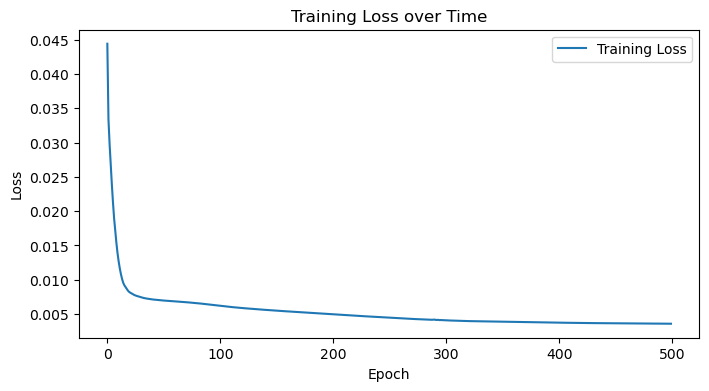

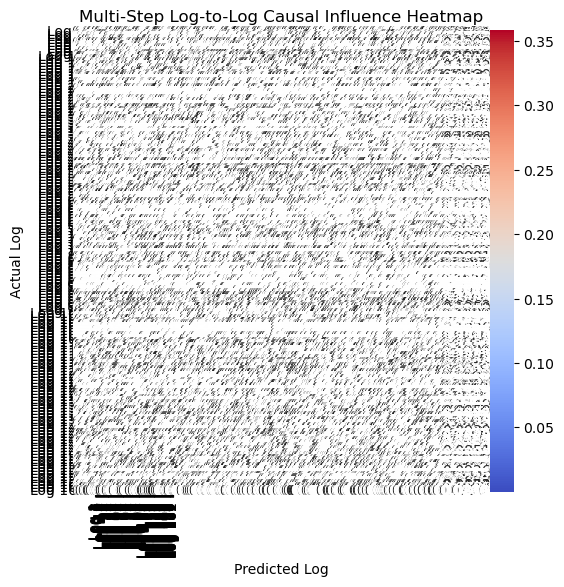

In [46]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================
# Step 1: Load Your Log Embeddings
# ==========================
# Replace this with your actual list of embeddings (must be a list of NumPy arrays or a 2D NumPy array)
your_embeddings_list = embeddings  # Replace with real embeddings

# Convert to NumPy array
embeddings_array = np.array(your_embeddings_list)

# Convert to PyTorch tensor
embedding_tensor = torch.tensor(embeddings_array, dtype=torch.float32)

# Check dimensions
num_logs, embedding_dim = embedding_tensor.shape
print(f"Loaded embeddings: {num_logs} logs, {embedding_dim}-dimensional each")

# ==========================
# Step 2: Define Multi-Step Causal LSTM Model
# ==========================
class MultiStepCausalLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_logs):
        super(MultiStepCausalLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, input_dim)  # Predict embeddings for all future logs

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out)  # Output has the same sequence length as input

# Instantiate Model
hidden_dim = 16  # Hidden state size
model = MultiStepCausalLSTM(embedding_dim, hidden_dim, num_logs)

# ==========================
# Step 3: Define Loss and Optimizer
# ==========================
criterion = nn.MSELoss()  # Predict future logs, compare with ground truth
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Prepare Data: Use full sequence as input, predicting future steps
train_data = embedding_tensor.unsqueeze(0)  # (1, num_logs, embedding_dim)

# ==========================
# Step 4: Train Model
# ==========================
epochs = 500
losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    output = model(train_data)  # Predict all future logs at once
    loss = criterion(output, train_data)  # Compare entire sequence
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# ==========================
# Step 5: Compute Multi-Step Causal Influence Matrix
# ==========================
with torch.no_grad():
    predictions = model(train_data).squeeze(0).numpy()

# Compute causal influence matrix (difference between predicted and actual embeddings)
causal_matrix = np.abs(predictions - embeddings_array).mean(axis=1)  # Mean error per log

# Convert to DataFrame for easy visualization
causal_df = pd.DataFrame(causal_matrix.reshape(num_logs, 1), 
                         index=[f"Log {i+1}" for i in range(num_logs)], 
                         columns=["Causal Influence Score"])
print("\nMulti-Step Causal Influence per Log:")
print(causal_df)

# ==========================
# Step 6: Visualize Results
# ==========================
plt.figure(figsize=(8, 4))
plt.plot(losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Time")
plt.legend()
plt.show()

# Causal Influence Heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(np.abs(predictions - embeddings_array), annot=True, cmap="coolwarm", fmt=".4f", 
            xticklabels=[f"Log {i+1}" for i in range(num_logs)],
            yticklabels=[f"Log {i+1}" for i in range(num_logs)])
plt.xlabel("Predicted Log")
plt.ylabel("Actual Log")
plt.title("Multi-Step Log-to-Log Causal Influence Heatmap")
plt.show()


Loaded embeddings: 162 logs, 768-dimensional each

Multi-Step Causal Influence Matrix:
         Causal Influence Score
Log 1                  0.064006
Log 2                  0.053900
Log 3                  0.041267
Log 4                  0.049923
Log 5                  0.063133
...                         ...
Log 158                0.046188
Log 159                0.026593
Log 160                0.061326
Log 161                0.064690
Log 162                0.054079

[162 rows x 1 columns]


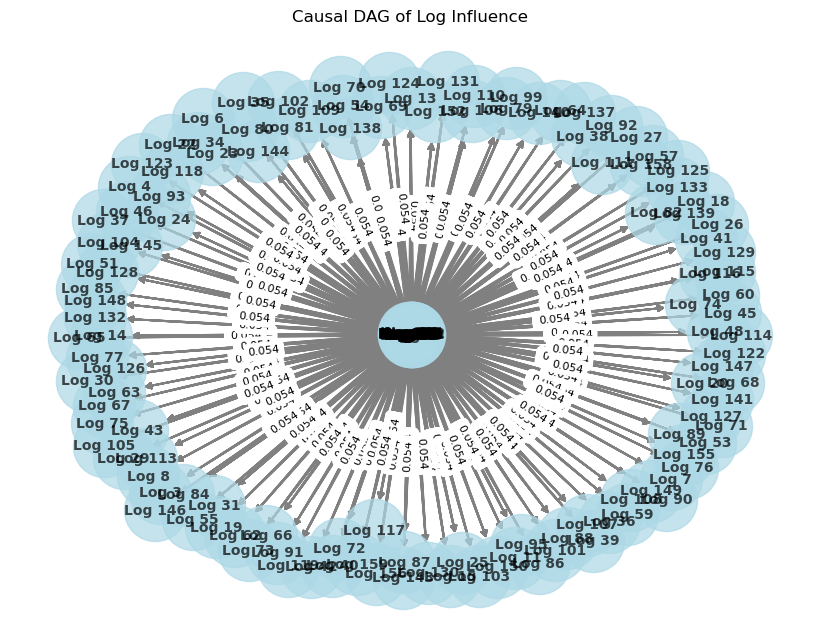

In [47]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import networkx as nx

# ==========================
# Step 1: Load Your Log Embeddings
# ==========================
# Replace this with your actual list of embeddings (must be a list of NumPy arrays or a 2D NumPy array)
your_embeddings_list = embeddings  # Replace with real embeddings

# Convert to NumPy array
embeddings_array = np.array(your_embeddings_list)

# Convert to PyTorch tensor
embedding_tensor = torch.tensor(embeddings_array, dtype=torch.float32)

# Check dimensions
num_logs, embedding_dim = embedding_tensor.shape
print(f"Loaded embeddings: {num_logs} logs, {embedding_dim}-dimensional each")

# ==========================
# Step 2: Define Multi-Step Causal LSTM Model
# ==========================
class MultiStepCausalLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_logs):
        super(MultiStepCausalLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, input_dim)  # Predict embeddings for all future logs

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out)  # Output has the same sequence length as input

# Instantiate Model
hidden_dim = 16  # Hidden state size
model = MultiStepCausalLSTM(embedding_dim, hidden_dim, num_logs)

# ==========================
# Step 3: Define Loss and Optimizer
# ==========================
criterion = nn.MSELoss()  # Predict future logs, compare with ground truth
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Prepare Data: Use full sequence as input, predicting future steps
train_data = embedding_tensor.unsqueeze(0)  # (1, num_logs, embedding_dim)

# ==========================
# Step 4: Train Model
# ==========================
epochs = 500
for epoch in range(epochs):
    optimizer.zero_grad()
    output = model(train_data)  # Predict all future logs at once
    loss = criterion(output, train_data)  # Compare entire sequence
    loss.backward()
    optimizer.step()

# ==========================
# Step 5: Compute Multi-Step Causal Influence Matrix
# ==========================
with torch.no_grad():
    predictions = model(train_data).squeeze(0).numpy()

# Compute causal influence matrix (difference between predicted and actual embeddings)
causal_matrix = np.abs(predictions - embeddings_array).mean(axis=1)  # Single mean to aggregate feature differences

# Convert to DataFrame for easy visualization
causality_df = pd.DataFrame(causal_matrix.reshape(num_logs, 1), 
                            index=[f"Log {i+1}" for i in range(num_logs)], 
                            columns=["Causal Influence Score"])

print("\nMulti-Step Causal Influence Matrix:")
print(causality_df)

# ==========================
# Step 6: Create a Directed Acyclic Graph (DAG) Representation
# ==========================
G = nx.DiGraph()

# Add nodes (log entries)
for i in range(num_logs):
    G.add_node(f"Log {i+1}")

# Add edges (causal relationships)
threshold = np.percentile(causality_df.values, 75)  # Use top 25% influences as significant links
for i in range(num_logs):
    for j in range(num_logs):
        if i != j and causality_df.iloc[i, 0] > threshold:  # Ignore self-loops, only add strong influences, uses row indexing
            G.add_edge(f"Log {i+1}", f"Log {j+1}", weight=causality_df.iloc[i, 0])  # Use row indexing


# ==========================
# Step 7: Visualize the DAG
# ==========================
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)  # Position nodes for better readability
edges = G.edges(data=True)
weights = [edata['weight'] for _, _, edata in edges]

# Draw nodes and edges
nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=2000, font_size=10, font_weight="bold", edge_color="gray", alpha=0.7)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{w['weight']:.3f}" for u, v, w in edges}, font_size=8)

plt.title("Causal DAG of Log Influence")
plt.show()


In [ ]:
import DrainMethod
import os


input_dir = os.path.join(os.getcwd(), "logs") # The input directory of raw logs
output_dir = os.path.join(os.getcwd(), "results")  # The output directory of parsing results
vector_dir = os.path.join(os.getcwd(), "vectors")  # The vector directory of converted logs
logName = 'Ciena_error_lines_20220701-20220715.txt' # Name of file to be parsed
log_format = '<Content>' # Format of the file, if there are different fields
regex = [] # Regex strings for Drain execution

## Parses logs using Drain
def parse_logs(log_file, st=0.5, depth=5):
    st = st # Drain similarity threshold
    depth = depth # Max depth of the parsing tree

    # Calls external Drain method
    parser = DrainMethod.LogParser(log_format=log_format, indir=input_dir, outdir=output_dir, rex=regex, depth=depth, st=st)
    parser.parse(log_file)

    parsedresult=os.path.join(output_dir, log_file + '_structured.csv')   

## Drain parameters
st = 0.5 # Drain similarity threshold
depth = 5 # Max depth of the parsing tree

## Parses file, using DrainMethod
print('\n=== Starting Drain Parsing ===')
indir = os.path.join(input_dir, os.path.dirname(logName))
print(indir)
log_file = os.path.basename(logName)

parser = DrainMethod.LogParser(log_format=log_format, indir=indir, outdir=output_dir, rex=regex, depth=depth, st=st)
parser.parse(log_file)

parsedresult=os.path.join(output_dir, log_file + '_structured.csv')






=== Starting Drain Parsing ===
/home/vbertalan/Downloads/Projetos/NewLogBERT/NewLogBert/tests/logs/


In [44]:
## Gets Templates as List

template_file = "results/" + logName + "_templates.csv"

import csv

def read_templates(file_path):
    """
    Reads a .csv file and returns a list containing values 
    from the second column of the file.
    
    :param file_path: Path to the .csv file
    :return: List of values from the second column
    """
    with open(file_path, 'r', encoding='utf-8') as file:
        reader = csv.reader(file)
        next(reader)  # Skip header if necessary
        template_column = [row[1] for row in reader if len(row) > 1]
    
    return template_column

parsed_templates = read_templates(template_file)

In [45]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2')

# Input list of texts
text_list = parsed_templates

# Tokenize the list of texts
inputs = tokenizer(text_list, padding=True, truncation=True, return_tensors='pt')

# Pass through the model
with torch.no_grad():  # Disable gradient calculation for efficiency
    outputs = model(**inputs)

# Extract embeddings (typically using the mean of the last hidden state)
embeddings = outputs.last_hidden_state.mean(dim=1)  # Shape: (batch_size, embedding_dim)

print(embeddings.shape)  # Should print (number_of_texts, embedding_dim)
print(embeddings)

torch.Size([162, 768])
tensor([[-0.0047,  0.1734,  0.0421,  ...,  0.1326, -0.1367, -0.1142],
        [-0.0330,  0.0197, -0.1275,  ...,  0.1037, -0.2586,  0.0418],
        [ 0.0622,  0.0940, -0.0389,  ..., -0.0837,  0.0009, -0.1187],
        ...,
        [-0.0248,  0.1219,  0.0391,  ..., -0.0752,  0.0860, -0.1888],
        [ 0.1559, -0.0023, -0.0538,  ...,  0.1380, -0.0588, -0.0481],
        [ 0.1138,  0.2106,  0.0442,  ...,  0.0276, -0.1261, -0.0814]])
